In [1]:
# resize the nerf_synthetic data

In [16]:
import os
import torch
import imageio
import numpy as np
import json
from PIL import Image
from typing import Literal, Optional, Tuple
import torchvision
from utils import calculate_focal_length, generate_rays
from torch.utils.data import DataLoader

path = os.environ["DATASET_PATH"]

In [31]:
def load_nerf_data(data_path:str, mode:Literal["train", "test", "val"], obj_name:str, resize:Optional[Tuple[int, int]]):
    # read the json file
    with open(os.path.join(data_path, f"transforms_{mode}.json"), "r") as f:
        data = json.load(f)
        
    # extract from json
    fov_x = data['camera_angle_x']
    pose = np.array([frame['transform_matrix'] for frame in data['frames']])
    N = pose.shape[0]
    
    # read all images 
    imgs = []
    for i in range(N):
        img = Image.open(os.path.join(data_path, f"{mode}", f"r_{i}.png"))
        if resize is not None:
            img = img.resize(resize)
        imgs.append(torchvision.transforms.functional.to_tensor(img))
    imgs = torch.stack(imgs, dim=0).float().transpose(1,2).transpose(2,3)
    if imgs.shape[-1] == 4:
        # compose the alpha
        imgs = imgs[..., :3] * imgs[..., 3:] # white? black? (1 - imgs[..., 3:])

    # image size & focal length for rays
    img_width = imgs.shape[1]
    img_height = imgs.shape[2]
    focal_length = calculate_focal_length(fov_x, img_width)
    total_n = img_width*img_height

    pixels = imgs.reshape((N, total_n, 3))
    # generate the rays
    rays_o = torch.zeros((N, total_n, 3))
    rays_d = torch.zeros((N, total_n, 3))
    
    for i in range(N):
        # FIXME later: duplicate computations
        o, d = generate_rays(img_width, img_height, int(focal_length), pose[i])
        o = torch.from_numpy(o)
        d = torch.from_numpy(d)
        rays_o[i] = o
        rays_d[i] = d
    return rays_o, rays_d, pixels, pose, (img_width, img_height, focal_length)

def create_dataloader(rays_o:torch.Tensor, rays_d:torch.Tensor, pixels:torch.Tensor, batch_size:int, shuffle:bool=True):
    # [batch(N*total_n), 3(ray_o, ray_d, img), 3]
    final = torch.cat((rays_o.reshape(-1, 3, 1), rays_d.reshape(-1, 3, 1), pixels.reshape(-1, 3, 1)), dim=-1)
    return DataLoader(final, batch_size=batch_size, shuffle=shuffle)

In [32]:
obj_name = "chair"
path = os.environ["DATASET_PATH"]
data_path = os.path.join(os.path.join(path, f"nerf_synthetic"),f"{obj_name}")
batch_size = 4096


train_rays_o, train_rays_d, train_pixels, pose, (w, h, f) = load_nerf_data(data_path, "train", obj_name, (400, 400))

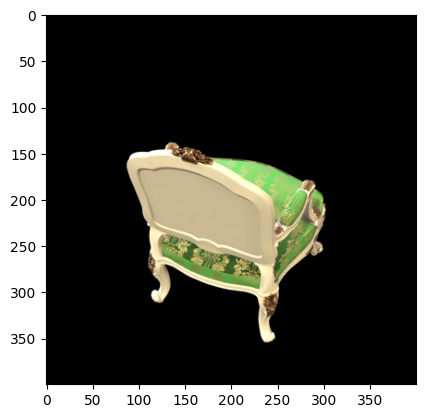

In [33]:
import matplotlib.pyplot as plt

plt.imshow(train_pixels[0].reshape(h, w, 3).numpy())
plt.show()

In [26]:
dataloader = create_dataloader(train_rays_o, train_rays_d, train_pixels, batch_size, shuffle=True)

for batch in dataloader:
    print(batch.shape)
    break

torch.Size([4096, 3, 3])
